#### library

In [62]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

code_directory = os.path.abspath('../code')  # 상위 디렉토리로 가서 b 디렉토리 경로
sys.path.append(code_directory)

from features import *
from preprocessing_fn import *
from preprocessing import *

from sklearn.neighbors import KDTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from utils.constant_utils import Directory
from utils import common_utils
import preprocessing
import preprocessing_fn

import model
from inference import *

#### data load

In [63]:
# file load

# train & test & submission load
data_path = "~/data"
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

# plus_info load
interest_data = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_data = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_data = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_data = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

In [25]:
print(train_data.shape, test_data.shape)
train_data.head(3)

(1801228, 11) (150172, 10)


,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0


In [84]:
test_data[test_data['age'] < 0]

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age


In [92]:
print("Start the main.py successfully!")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

# 클러스터 피처 apply
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=15)

# 이상치 처리
print("start to cleaning outliers...")
df = preprocessing_fn.handle_outliers(df)
df = df[df['age'] >= 0]

train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)

# 중복 제거
print("start to preprocessing...")
train_data_ = preprocessing_fn.handle_duplicates(train_data_)
valid_data_ = preprocessing_fn.handle_duplicates(valid_data_)

Start the main.py successfully!
start to cleaning outliers...
start to preprocessing...


In [95]:
train_data_ = preprocessing.time_feature_preprocessing(train_data_)
valid_data_ = preprocessing.time_feature_preprocessing(valid_data_)
test_data_ = preprocessing.time_feature_preprocessing(test_data_)

In [ ]:
### 금리 shift 함수
def shift_interest_rate_function(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame, month : int = 3) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data_length = len(train_data)
    valid_data_length = len(valid_data)
    test_data_length = len(test_data)
    
    total_data = pd.concat([train_data[['date','interest_rate']],valid_data[['date','interest_rate']],test_data[['date','interest_rate']]], axis=0)
    
    # 원래의 인덱스 저장
    total_data['original_index'] = total_data.index
    
    # 데이터 정렬 (date 기준)
    df_sorted = df.sort_values('date').reset_index(drop=True)

    # 과거 금리 정보 구하기
    df_sorted['date_minus_1year'] = df_sorted['date'] - pd.DateOffset(years=1)
    df_sorted['date_minus_6months'] = df_sorted['date'] - pd.DateOffset(months=6)
    df_sorted['date_minus_3months'] = df_sorted['date'] - pd.DateOffset(months=3)

    df_sorted = pd.merge_asof(
        df_sorted, 
        df_sorted[['date', 'interest_rate']], 
        left_on='date_minus_1year', 
        right_on='date', 
        direction='backward', 
        suffixes=('', '_1year')
    )

    df_sorted = pd.merge_asof(
        df_sorted, 
        df_sorted[['date', 'interest_rate']], 
        left_on='date_minus_6months', 
        right_on='date', 
        direction='backward', 
        suffixes=('', '_6months')
    )

    df_sorted = pd.merge_asof(
        df_sorted, 
        df_sorted[['date', 'interest_rate']], 
        left_on='date_minus_3months', 
        right_on='date', 
        direction='backward', 
        suffixes=('', '_3months')
    )
    
    # 필요 없는 중간 날짜 컬럼(drop)
    df_sorted = df_sorted.drop(columns=['date_minus_1year', 'date_1year', 'date_minus_6months', 'date_6months', 'date_minus_3months', 'date_3months'])

    df_sorted['interest_rate_3months'] = df_sorted['interest_rate_3months'].fillna(df_sorted['interest_rate'])
    df_sorted['interest_rate_6months'] = df_sorted['interest_rate_6months'].fillna(df_sorted['interest_rate'])
    df_sorted['interest_rate_1year'] = df_sorted['interest_rate_1year'].fillna(df_sorted['interest_rate'])

    df_final = df_sorted.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)

    train_data_ = df_final.iloc[:train_data_length,:]
    valid_data_ = df_final.iloc[train_data_length:train_data_length+valid_data_length,:]
    test_data_ = df_final.iloc[train_data_length+valid_data_length:,:]
        
    return train_data_, valid_data_, test_data_


##### transaction feature engineering

In [107]:
def transaction_count_function(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame, month : int = 3) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data_length = len(train_data)
    valid_data_length = len(valid_data)
    test_data_length = len(test_data)
    
    train_data_tot = pd.concat([train_data, valid_data], axis=0)
    total_data = pd.concat([train_data_tot, test_data], axis=0)
    
    total_data['transaction_count_last_3_months'] = 0
    
    # 위도, 경도, 건축 연도로 그룹화
    grouped = total_data.groupby(['latitude', 'longitude', 'built_year'])
    
    # 각 그룹에 대해 거래량 계산
    for (lat, lon, built_year), group in tqdm(grouped, desc="Calculating previous 3 months transaction counts by location and year"):
    # 그룹 내 거래일 정렬
        group = group.sort_values(by='date')
    
        # 거래량을 저장할 리스트 초기화
        transaction_counts = []

        for idx, row in group.iterrows():
            # 현재 거래일로부터 month 이전 날짜 계산
            end_date = row['date']
            start_date = end_date - pd.DateOffset(months=month)

            # 동일한 아파트에서의 거래량 계산
            transaction_count = group[
                (group['date'] < end_date) &  # 현재 거래일 이전
                (group['date'] >= start_date)  # month 이전 
                ].shape[0]

            # 거래량 리스트에 추가
            transaction_counts.append(transaction_count)

        # 배치 결과를 데이터프레임에 저장
        total_data.loc[group.index, 'transaction_count_last_3_months'] = transaction_counts

    train_data_ = total_data.iloc[:train_data_length,:]
    valid_data_ = total_data.iloc[train_data_length:train_data_length+valid_data_length,:]
    test_data_ = total_data.iloc[train_data_length+valid_data_length:,:]
        
    return train_data_, valid_data_, test_data_

In [108]:
train_data_, valid_data_, test_data_ = transaction_count_function(train_data_, valid_data_, test_data_)

Calculating previous 3 months transaction counts by location and year: 100%|██████████| 19103/19103 [31:25<00:00, 10.13it/s]  


In [111]:
# saving data and load function
def save_and_load_function(data: list, file_name: str, mode: str) -> list:
    # 저장 경로 설정
    save_path = os.path.join(Directory.root_path, "level2-competitiveds-recsys-01/data/transaction_data", file_name + ".txt")
    
    # save 모드일 때
    if mode == 'save':
        # 리스트 데이터를 txt 형식으로 저장
        with open(save_path, 'w') as f:
            for item in data:
                f.write(f"{item}\n")  # 각 리스트 항목을 한 줄씩 저장
    
    # load 모드일 때
    elif mode == 'load':
        # txt 파일을 불러와 리스트로 변환
        loaded_data = []
        if os.path.exists(save_path):  # 파일이 존재할 때만 실행
            with open(save_path, 'r') as f:
                loaded_data = f.read().splitlines()  # 각 줄을 리스트의 항목으로 변환
        return loaded_data
    
    else:
        raise ValueError("mode should be either 'save' or 'load'")  # 잘못된 모드 처리

In [114]:
save_and_load_function(train_data_['transaction_count_last_3_months'].to_list(), 'train_transaction', 'save')
save_and_load_function(valid_data_['transaction_count_last_3_months'].to_list(), 'valid_transaction', 'save')
save_and_load_function(test_data_['transaction_count_last_3_months'].to_list(), 'test_transaction', 'save')

#### feature engineering

In [ ]:
new_df_filtered = train_data_.copy()

##### floor

In [27]:
### floor
new_df_filtered['floor'].value_counts()

floor
 4     119132
 5     118267
 3     114938
 2     109981
 6     107136
        ...  
 66         2
 64         1
-4          1
 67         1
-3          1
Name: count, Length: 73, dtype: int64

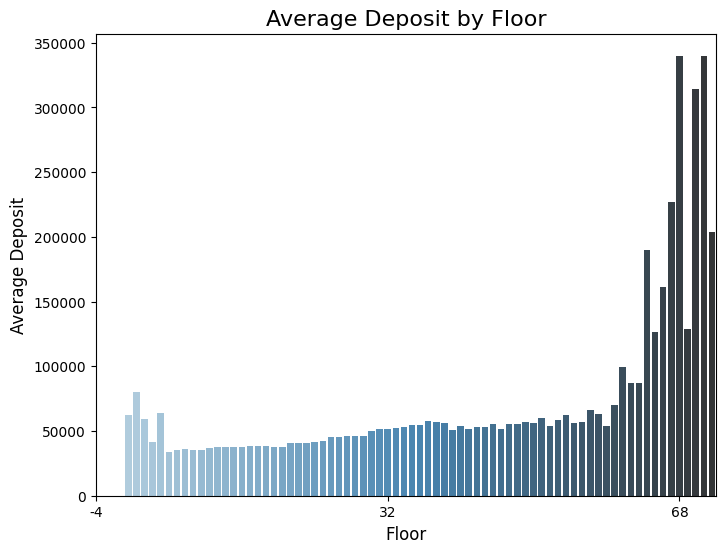

In [28]:
# 'floor'에 따른 'deposit'의 평균 계산
df_grouped = new_df_filtered.groupby('floor')['deposit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='floor', y='deposit', data=df_grouped, palette='Blues_d')

plt.title('Average Deposit by Floor', fontsize=16)
plt.xlabel('Floor', fontsize=12)
plt.ylabel('Average Deposit', fontsize=12)

xticks = [df_grouped['floor'].min(), df_grouped['floor'].median(), df_grouped['floor'].max()]
plt.xticks(ticks=xticks, labels=[int(xticks[0]), int(xticks[1]), int(xticks[2])])

plt.show()

In [29]:
bins = [-float('inf'), 0, 15, 30, 45, 60, float('inf')]
labels = ['Basement', '0~15', '15~30', '30~45', '45~60', '60+']

new_df_filtered['floor_category'] = pd.cut(new_df_filtered['floor'], bins=bins, labels=labels)
new_df_filtered.head(3)

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,month,date,day_of_week,quarter,is_month_end,season,season_sin,season_cos,floor_area_interaction,floor_category
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,6,2019-06-25,1,2,0,Summer,1.0,6.123234e-17,764.9829,0~15
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,3,2020-03-26,3,1,0,Spring,0.0,1.000000e+00,1699.9620,15~30
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,3,2020-03-28,5,1,0,Spring,0.0,1.000000e+00,679.9848,0~15


floor_category
0~15        1465561
15~30        309744
30~45         20183
45~60          2177
Basement         70
60+              42
Name: count, dtype: int64


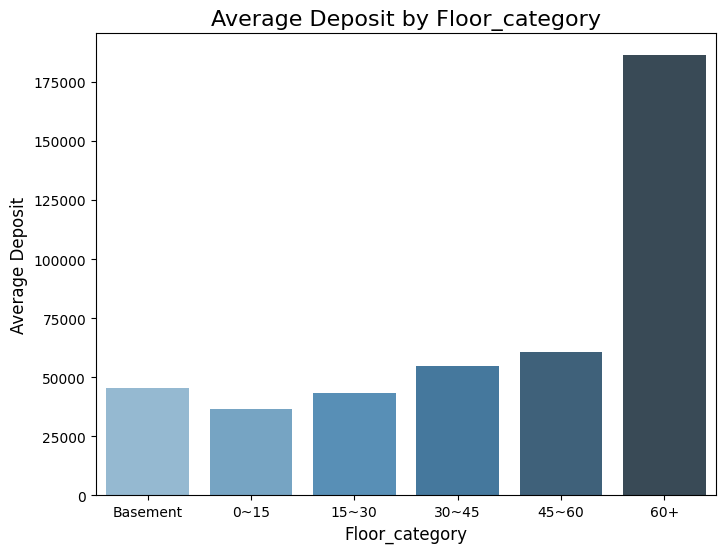

In [30]:
# 'floor'에 따른 'deposit'의 평균 계산
print(new_df_filtered['floor_category'].value_counts())

df_grouped = new_df_filtered.groupby('floor_category')['deposit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='floor_category', y='deposit', data=df_grouped, palette='Blues_d')

plt.title('Average Deposit by Floor_category', fontsize=16)
plt.xlabel('Floor_category', fontsize=12)
plt.ylabel('Average Deposit', fontsize=12)

plt.show()

In [31]:
# floor 값을 그대로 유지하되, 0 이하와 60 이상 값은 'Other'로 범주화
new_df_filtered['new_floor_category'] = new_df_filtered['floor'].apply(lambda x: 'Other' if x <= 0 or x >= 30 else ('25~30' if 25 <= x <= 30 else x))
new_df_filtered.head(3)

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,date,day_of_week,quarter,is_month_end,season,season_sin,season_cos,floor_area_interaction,floor_category,new_floor_category
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,2019-06-25,1,2,0,Summer,1.0,6.123234e-17,764.9829,0~15,9
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,2020-03-26,3,1,0,Spring,0.0,1.000000e+00,1699.9620,15~30,20
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,2020-03-28,5,1,0,Spring,0.0,1.000000e+00,679.9848,0~15,8


new_floor_category
4        119132
5        118267
3        114938
2        109981
6        107136
7        102144
8         97891
9         97255
10        96023
1         91377
11        89857
12        88224
13        82126
14        78313
15        72897
16        46983
17        43509
18        39942
25~30     39905
19        34462
20        30226
Other     26265
21        21005
22        19072
23        16588
24        14259
Name: count, dtype: int64


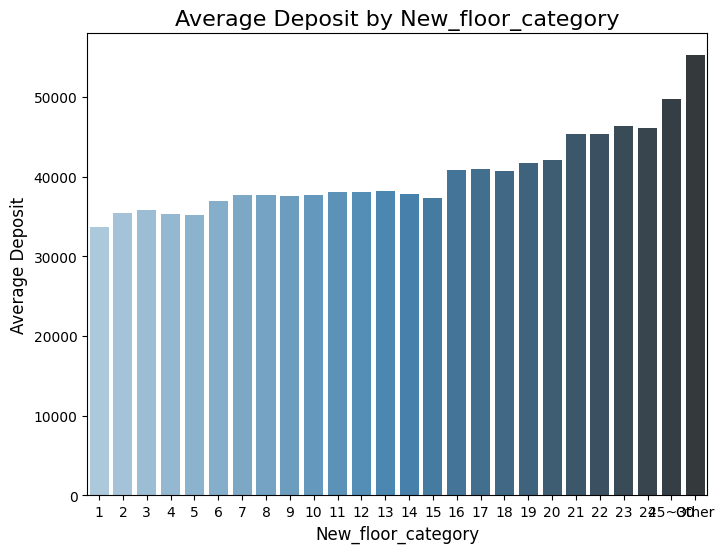

In [32]:
# 'floor'에 따른 'deposit'의 평균 계산
print(new_df_filtered['new_floor_category'].value_counts())

df_grouped = new_df_filtered.groupby('new_floor_category')['deposit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='new_floor_category', y='deposit', data=df_grouped, palette='Blues_d')

plt.title('Average Deposit by New_floor_category', fontsize=16)
plt.xlabel('New_floor_category', fontsize=12)
plt.ylabel('Average Deposit', fontsize=12)

plt.show()

##### age

In [33]:
### floor
new_df_filtered['age'].value_counts()

age
0     83870
2     81553
4     71318
26    58955
27    58190
      ...  
60        5
62        5
61        5
59        2
58        2
Name: count, Length: 63, dtype: int64

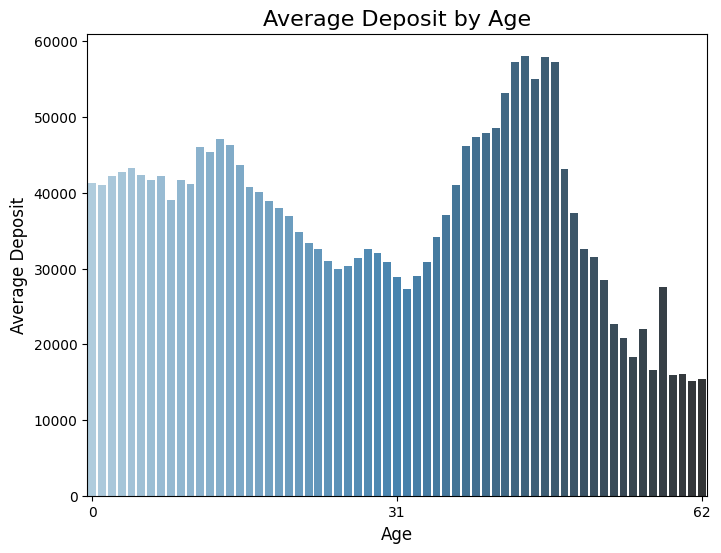

In [34]:
# 'floor'에 따른 'deposit'의 평균 계산
df_grouped = new_df_filtered.groupby('age')['deposit'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='age', y='deposit', data=df_grouped, palette='Blues_d')

plt.title('Average Deposit by Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Deposit', fontsize=12)

xticks = [df_grouped['age'].min(), df_grouped['age'].median(), df_grouped['age'].max()]
plt.xticks(ticks=xticks, labels=[int(xticks[0]), int(xticks[1]), int(xticks[2])])

plt.show()

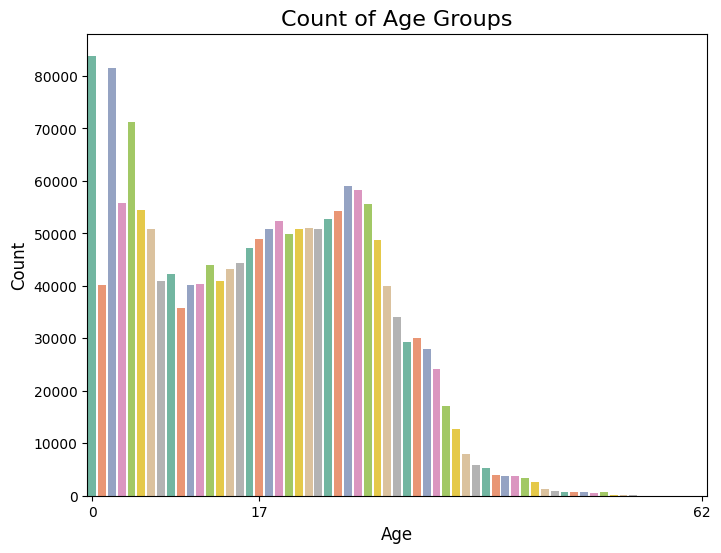

In [35]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age', data=new_df_filtered, palette='Set2')

# 그래프 제목과 축 레이블 설정
plt.title('Count of Age Groups', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)


xticks = [new_df_filtered['age'].min(), new_df_filtered['age'].median(), new_df_filtered['age'].max()]
plt.xticks(ticks=xticks, labels=[int(xticks[0]), int(xticks[1]), int(xticks[2])])

# 그래프 출력
plt.show()

In [36]:
# age 값을 그대로 유지하되, 55 이상 값은 'Other'로 범주화
new_df_filtered['new_age_category'] = new_df_filtered['age'].apply(lambda x: 'Other' if x >= 50 else x)
new_df_filtered.head(3)

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,day_of_week,quarter,is_month_end,season,season_sin,season_cos,floor_area_interaction,floor_category,new_floor_category,new_age_category
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1,2,0,Summer,1.0,6.123234e-17,764.9829,0~15,9,0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,3,1,0,Spring,0.0,1.000000e+00,1699.9620,15~30,20,1
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,5,1,0,Spring,0.0,1.000000e+00,679.9848,0~15,8,1


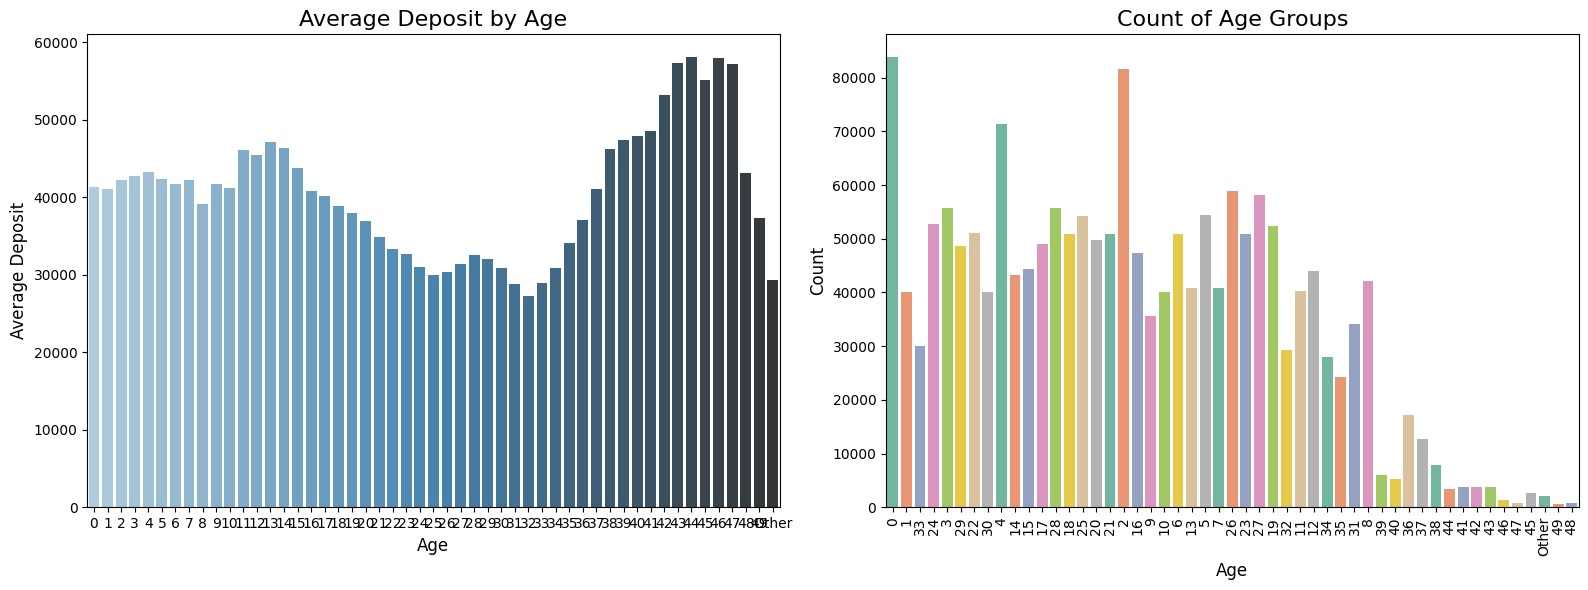

In [37]:
df_grouped = new_df_filtered.groupby('new_age_category')['deposit'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 평균 deposit by age
sns.barplot(x='new_age_category', y='deposit', data=df_grouped, palette='Blues_d', ax=axes[0])
axes[0].set_title('Average Deposit by Age', fontsize=16)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Average Deposit', fontsize=12)

plt.xticks(rotation=90)


# 2. Count of Age Groups
sns.countplot(x='new_age_category', data=new_df_filtered, palette='Set2', ax=axes[1])
axes[1].set_title('Count of Age Groups', fontsize=16)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### test with standarization

In [46]:
print("Start the main.py successfully!")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)

# 클러스터 피처 apply
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(df, info_df, feat_name=info_df_name, n_clusters=15)

# 이상치 처리
print("start to cleaning outliers...")
df = preprocessing_fn.handle_outliers(df)

train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)

# 중복 제거
print("start to preprocessing...")
train_data_ = preprocessing_fn.handle_duplicates(train_data_)
valid_data_ = preprocessing_fn.handle_duplicates(valid_data_)

# 전처리 적용
train_data_ = preprocessing.time_feature_preprocessing(train_data_)
valid_data_ = preprocessing.time_feature_preprocessing(valid_data_)
test_data_ = preprocessing.time_feature_preprocessing(test_data_)

# 새로운 피처 추가
print("start to feature engineering...")
train_data_, valid_data_, test_data_ = create_nearest_subway_distance(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_subway_within_radius(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_nearest_park_distance_and_area(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_school_within_radius(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = create_place_within_radius(train_data_, valid_data_, test_data_)
train_data_, valid_data_, test_data_ = categorization(train_data_, valid_data_, test_data_, category = 'age')
train_data_, valid_data_, test_data_ = categorization(train_data_, valid_data_, test_data_ , category = 'floor')


Start the main.py successfully!


start to cleaning outliers...
start to preprocessing...
start to feature engineering...


In [47]:
train_data_.head(3)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,...,season_cos,floor_area_interaction,nearest_subway_distance,subways_within_radius,nearest_park_distance,nearest_park_area,schools_within_radius,public_facility_count,new_age_category,new_floor_category
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,...,6.123234e-17,764.9829,0.00791,1,0.004779,8285.0,2,3,0,9
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,...,1.000000e+00,1699.9620,0.00791,1,0.004779,8285.0,2,3,1,20
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,...,1.000000e+00,679.9848,0.00791,1,0.004779,8285.0,2,3,1,8


In [48]:
train_data_.columns

Index(['area_m2', 'contract_year_month', 'contract_day', 'contract_type',
       'floor', 'built_year', 'latitude', 'longitude', 'age', 'deposit',
       'type', 'interest_rate', 'subway_info', 'school_info', 'park_info',
       'year', 'month', 'date', 'day_of_week', 'quarter', 'is_month_end',
       'season', 'season_sin', 'season_cos', 'floor_area_interaction',
       'nearest_subway_distance', 'subways_within_radius',
       'nearest_park_distance', 'nearest_park_area', 'schools_within_radius',
       'public_facility_count', 'new_age_category', 'new_floor_category'],
      dtype='object')

In [49]:
categorical_columns = ['contract_type', 'new_age_category', 'new_floor_category', 'subway_info','school_info' ,'park_info','month','subways_within_radius','schools_within_radius','public_facility_count']
numerical_columns = ['area_m2','contract_year_month','contract_day','latitude','longitude','floor_area_interaction','interest_rate','nearest_subway_distance','nearest_park_distance', 'nearest_park_area']
target = ['deposit']

In [50]:
# numerical 정규화
train_data_num, valid_data_num, test_data_num = preprocessing_fn.standardization(train_data_[numerical_columns], valid_data_[numerical_columns], test_data_[numerical_columns], scaling_type = 'standard')

In [51]:
def preprocess_data(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame, categorical_list: list, numerical_list: list, scaling_type: str = 'standard') -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    train_data = train_data[numerical_list + categorical_list]
    valid_data = valid_data[numerical_list + categorical_list]
    test_data = test_data[numerical_list + categorical_list]
    
    # 수치형 변수 스케일링
    if scaling_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    train_data_scaled = train_data.copy()
    train_data_scaled[numerical_list] = scaler.fit_transform(train_data[numerical_list])

    valid_data_scaled = valid_data.copy()
    valid_data_scaled[numerical_list] = scaler.transform(valid_data[numerical_list])

    test_data_scaled = test_data.copy()
    test_data_scaled[numerical_list] = scaler.transform(test_data[numerical_list])

    # 범주형 변수 One-Hot Encoding
    # 유효한 범주형 변수 확인
    for cat in categorical_list:
        if cat not in train_data.columns or cat not in valid_data.columns or cat not in test_data.columns:
            raise ValueError(f"Column '{cat}' is not found in all datasets.")

    train_data_encoded = pd.get_dummies(train_data_scaled, columns=categorical_list, drop_first=True)
    valid_data_encoded = pd.get_dummies(valid_data_scaled, columns=categorical_list, drop_first=True)
    test_data_encoded = pd.get_dummies(test_data_scaled, columns=categorical_list, drop_first=True)

    # train, valid, test 데이터 간의 column mismatch 해결 (같은 칼럼으로 맞추기 위해 reindex 사용)
    valid_data_encoded = valid_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)
    test_data_encoded = test_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

    return train_data_encoded, valid_data_encoded, test_data_encoded

In [52]:
train_data_pre, valid_data_pre, test_data_pre =  preprocess_data(train_data_, valid_data_, test_data_, categorical_columns, numerical_columns)

In [53]:
train_data_ = pd.concat([train_data_pre, train_data_[['type', 'season', 'date','deposit']]], axis=1)
valid_data_ = pd.concat([valid_data_pre, valid_data_[['type', 'season', 'date','deposit']]], axis=1)
test_data_ = pd.concat([test_data_pre, test_data_[['type', 'season', 'date','deposit']]], axis=1)

In [54]:
# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing_fn.feature_selection(train_data_, valid_data_, test_data_)

# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

# train model
print("Train the model")
model_ = model.xgboost(X_train, y_train)

prediction, mae = inference(model_, 'validation', X_valid, y_valid)

# train with total dataset
print("Train with total dataset")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

# inference with test data
print("inference with test dataset")
submission = inference(model_, 'submission', X_test)
print("train mae :", mae)


Train the model
Train with total dataset
inference with test dataset
train mae : 5153.211132091156


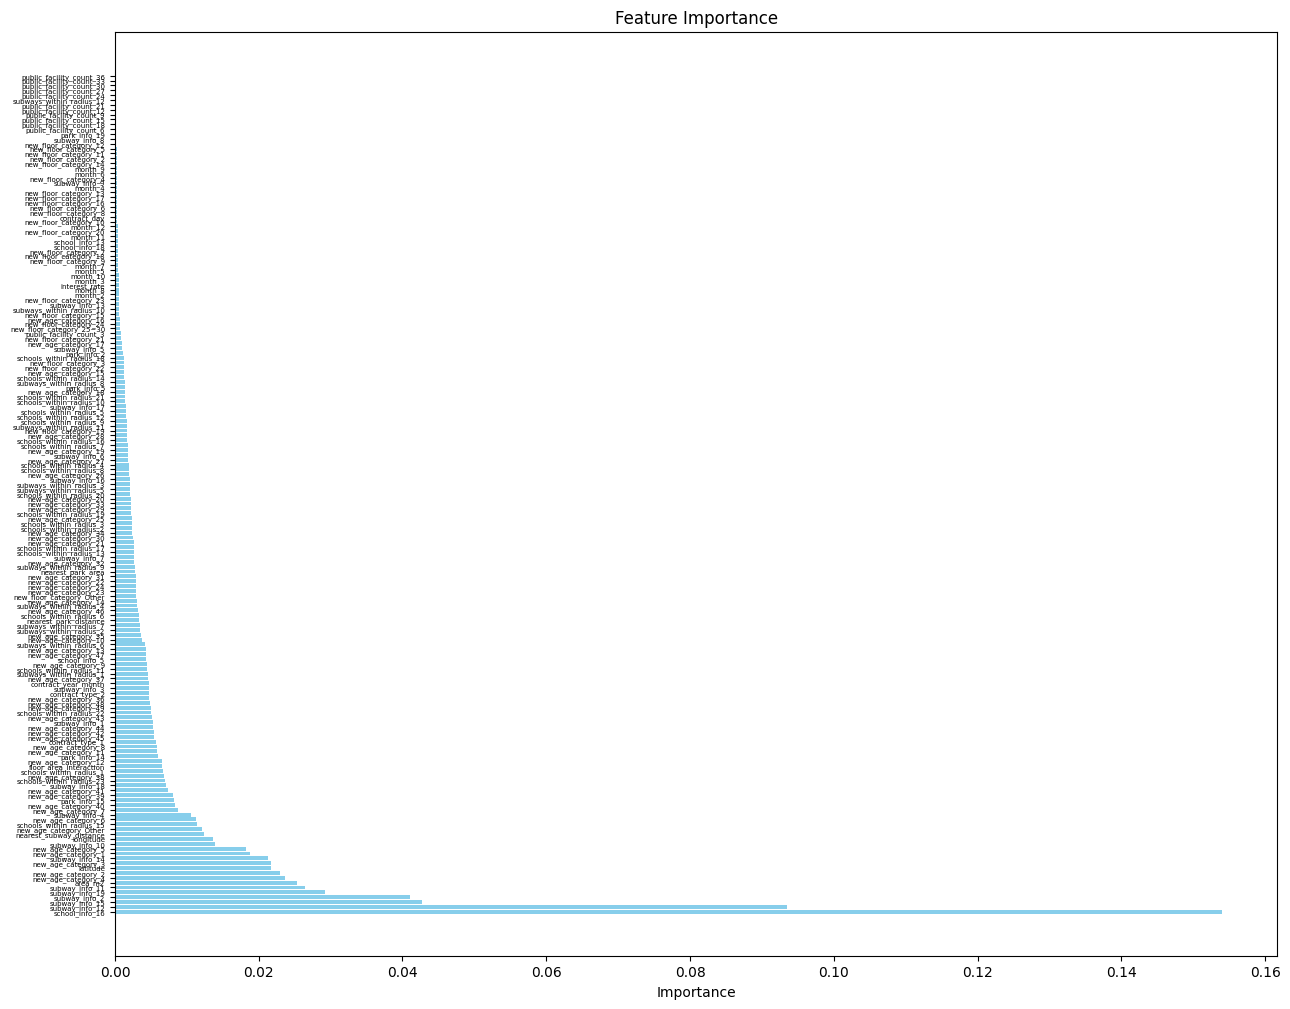

In [61]:
# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=5)
plt.title('Feature Importance')
plt.show()

In [42]:
# train lightgbm model
print("Train the model")
model_ = model.lightgbm(X_train, y_train)

prediction, mae = inference(model_, 'validation', X_valid, y_valid)

# train with total dataset
print("Train with total dataset")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.lightgbm(X_total, y_total)

# inference with test data
print("inference with test dataset")
submission = inference(model_, 'submission', X_test)
print("train mae :", mae)


Train the model
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2238
[LightGBM] [Info] Number of data points in the train set: 1515867, number of used features: 171
[LightGBM] [Info] Start training from score 37853.227009
Train with total dataset
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 1714416, number of used features: 171
[LightGBM] [Info] Start training from score 38207.326595
inference with test dataset
train mae : 6946.3736501825315
